In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:26]) == "AOI_3_Paris"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1071.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1847.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1822.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img280.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img202.tif')]

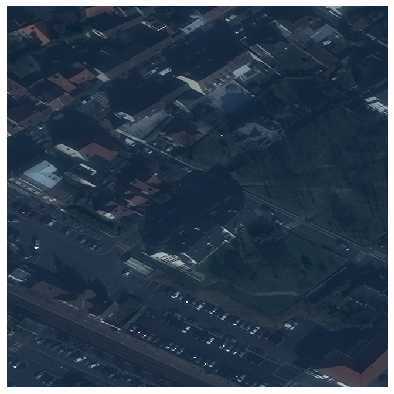

In [6]:
img = open_image(fname[4])
img.show(figsize=(7,7))

In [7]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Paris_buildings.csv")

In [5]:
paris_df = pd.read_csv(path/'Paris_buildings.csv')
paris_df = paris_df.drop(columns = 'Unnamed: 0')
paris_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_3_Paris_img1071.tif
1,Images/RGB-PanSharpen_AOI_3_Paris_img1847.tif
2,Images/RGB-PanSharpen_AOI_3_Paris_img1822.tif
3,Images/RGB-PanSharpen_AOI_3_Paris_img280.tif
4,Images/RGB-PanSharpen_AOI_3_Paris_img202.tif


In [6]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [ ]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [7]:
len(paris_df)

1148

In [8]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(paris_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [12]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = None, max_zoom=1.1, max_lighting = 0.5), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

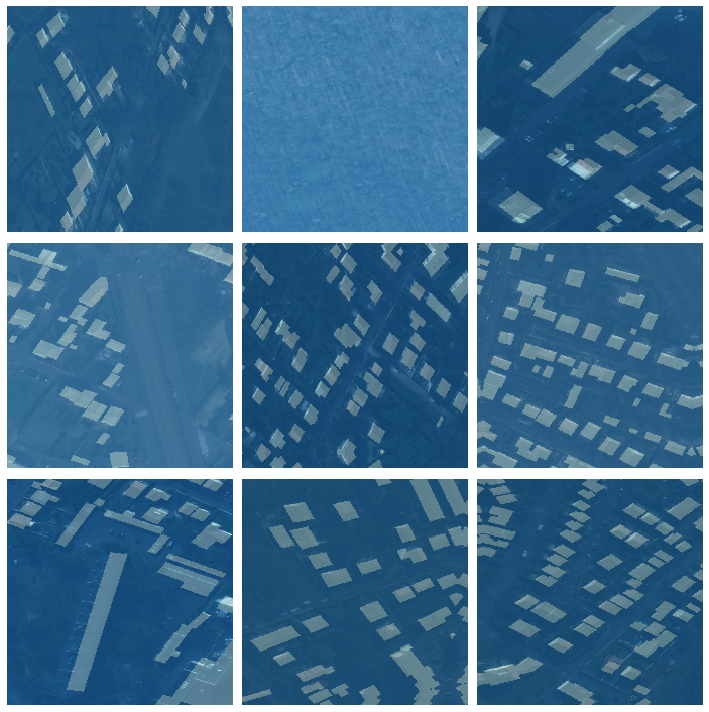

In [13]:
data.show_batch(3, figsize=(10,10))

In [19]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True)
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


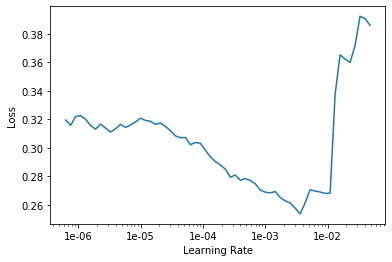

In [20]:
learn.lr_find()
learn.recorder.plot() 

In [21]:
learn.fit_one_cycle(5, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.220645,0.174560,0.220333,00:16
1,0.182440,0.131253,0.128092,00:16
2,0.156349,0.110430,0.386335,00:16
3,0.139261,0.108256,0.452798,00:16
4,0.129873,0.104068,0.432849,00:16


In [22]:
save_model(learn, 'Paris', 'F', 'smol', 1)

# Start Recording

In [9]:
import wandb
from wandb.fastai import WandbCallback

In [24]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [25]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Paris.ipynb"

In [26]:
wandb.init(project="spacenet_buildings", name = 'Paris_smol')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/gnw82pfa

In [27]:
load_model(learn, 'Paris', 'F', 'smol', 1)

In [28]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.118411,0.103629,0.441196,00:18
1,0.116459,0.101892,0.451758,00:17
2,0.118647,0.114748,0.473676,00:17
3,0.117621,0.098899,0.459888,00:17
4,0.117601,0.097134,0.488777,00:17
5,0.126772,0.115222,0.454201,00:17
6,0.124012,0.106765,0.485028,00:17
7,0.117083,0.092802,0.486372,00:17
8,0.110046,0.092187,0.506810,00:17
9,0.106878,0.091366,0.511324,00:17


Better model found at epoch 0 with valid_loss value: 0.1036289781332016.
Better model found at epoch 1 with valid_loss value: 0.1018923819065094.
Better model found at epoch 3 with valid_loss value: 0.09889934957027435.
Better model found at epoch 4 with valid_loss value: 0.09713426977396011.
Better model found at epoch 7 with valid_loss value: 0.09280183911323547.
Better model found at epoch 8 with valid_loss value: 0.0921870619058609.
Better model found at epoch 9 with valid_loss value: 0.09136579930782318.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_105221-gnw82pfa/bestmodel.pth


In [30]:
save_model(learn, 'Paris', 'F', 'smol', 2)

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.101641,0.091045,0.514233,00:18
1,0.100664,0.090349,0.514528,00:18
2,0.100510,0.091404,0.535505,00:18
3,0.101170,0.091041,0.520328,00:18
4,0.099940,0.091949,0.545951,00:18
5,0.099958,0.090624,0.547023,00:18
6,0.099139,0.086986,0.531630,00:18
7,0.098721,0.088388,0.551153,00:18
8,0.097907,0.085452,0.555888,00:18
9,0.097277,0.085501,0.557954,00:18


Better model found at epoch 0 with valid_loss value: 0.09104478359222412.
Better model found at epoch 1 with valid_loss value: 0.09034918993711472.
Better model found at epoch 6 with valid_loss value: 0.08698638528585434.
Better model found at epoch 8 with valid_loss value: 0.08545201271772385.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_105221-gnw82pfa/bestmodel.pth


In [33]:
save_model(learn, 'Paris', 'UF', 'smol', 1)

In [34]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.093094,0.085264,0.556521,00:18
1,0.094777,0.085116,0.558359,00:18
2,0.095365,0.085447,0.557534,00:18
3,0.094692,0.085153,0.556358,00:18
4,0.094970,0.085239,0.555081,00:18
5,0.095119,0.085669,0.555192,00:18
6,0.093967,0.085748,0.558296,00:18
7,0.094402,0.085935,0.555617,00:18
8,0.093454,0.085383,0.553706,00:18
9,0.093181,0.085795,0.552142,00:18


Better model found at epoch 0 with valid_loss value: 0.08526428043842316.
Better model found at epoch 1 with valid_loss value: 0.08511554449796677.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_105221-gnw82pfa/bestmodel.pth


In [35]:
save_model(learn, 'Paris', 'UF', 'smol', 2)

## GO BIG

In [10]:
bs = 8
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = None, max_zoom=1.1, max_lighting = 0.5), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [11]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss

In [14]:
load_model(learn, 'Paris', 'UF', 'smol', 2)

In [15]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Paris.ipynb"

In [16]:
wandb.init(project="spacenet_buildings", name = 'Paris_Big_SA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/ht99o4cw

In [17]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.100523,0.104266,0.580667,00:58
1,0.097304,0.105615,0.568210,00:48
2,0.104885,0.176755,0.368600,00:48
3,0.101169,0.106879,0.560658,00:48
4,0.094209,0.101175,0.610825,00:48
5,0.095955,0.142642,0.329477,00:48
6,0.085577,0.100572,0.597106,00:48
7,0.089657,0.097943,0.619922,00:48
8,0.082958,0.092986,0.632541,00:48
9,0.078928,0.090668,0.631772,00:48


Better model found at epoch 0 with valid_loss value: 0.10426601022481918.
Better model found at epoch 4 with valid_loss value: 0.10117464512586594.
Better model found at epoch 6 with valid_loss value: 0.10057154297828674.
Better model found at epoch 7 with valid_loss value: 0.09794281423091888.
Better model found at epoch 8 with valid_loss value: 0.09298551082611084.
Better model found at epoch 9 with valid_loss value: 0.09066832065582275.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [21]:
save_model(learn, 'Paris', 'F', 'big', 1)

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.5)

epoch,train_loss,valid_loss,dice,time
0,0.077289,0.090250,0.635778,00:50
1,0.078126,0.090732,0.642759,00:50
2,0.081790,0.089576,0.636494,00:50
3,0.075020,0.089983,0.637731,00:50
4,0.079736,0.098848,0.636765,00:50
5,0.073559,0.088133,0.639816,00:50
6,0.075852,0.086645,0.653957,00:50
7,0.076915,0.086842,0.644453,00:50
8,0.072390,0.086925,0.649350,00:50
9,0.070507,0.086205,0.651547,00:50


Better model found at epoch 0 with valid_loss value: 0.0902501791715622.
Better model found at epoch 2 with valid_loss value: 0.08957606554031372.
Better model found at epoch 5 with valid_loss value: 0.08813253045082092.
Better model found at epoch 6 with valid_loss value: 0.08664514124393463.
Better model found at epoch 9 with valid_loss value: 0.08620475977659225.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [24]:
save_model(learn, 'Paris', 'UF', 'big', 1)

In [25]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.070594,0.086425,0.650455,00:49
1,0.073425,0.086479,0.648111,00:50
2,0.074345,0.086523,0.652389,00:50
3,0.071257,0.084650,0.655320,00:50
4,0.072060,0.085297,0.652618,00:50
5,0.071608,0.085884,0.646897,00:50
6,0.072644,0.085905,0.657069,00:50
7,0.071081,0.085157,0.652314,00:50
8,0.070106,0.084972,0.655156,00:50
9,0.070309,0.084708,0.657418,00:50


Better model found at epoch 0 with valid_loss value: 0.08642452955245972.
Better model found at epoch 3 with valid_loss value: 0.08465038239955902.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [26]:
save_model(learn, 'Paris', 'UF', 'big', 2)

In [27]:
learn.fit_one_cycle(5, slice(5e-5, 5e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.070471,0.086500,0.657575,00:49
1,0.079387,0.097732,0.587782,00:50
2,0.085809,0.107173,0.598921,00:50
3,0.080453,0.090688,0.630255,00:49
4,0.072718,0.087736,0.649006,00:50


Better model found at epoch 0 with valid_loss value: 0.08650008589029312.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [ ]:
load_model(learn, 'Paris', 'UF', 'big', 2)

In [28]:
learn.fit_one_cycle(10, slice(5e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.071059,0.085708,0.652319,00:50
1,0.069904,0.085893,0.648662,00:49
2,0.072653,0.086403,0.650987,00:49
3,0.071410,0.087908,0.636397,00:50
4,0.074076,0.084315,0.658144,00:50
5,0.071408,0.084411,0.652369,00:50
6,0.072095,0.085275,0.662580,00:50
7,0.070572,0.085985,0.649245,00:50
8,0.066866,0.083231,0.661791,00:50
9,0.070144,0.083671,0.657054,00:50


Better model found at epoch 0 with valid_loss value: 0.08570840954780579.
Better model found at epoch 4 with valid_loss value: 0.0843152180314064.
Better model found at epoch 8 with valid_loss value: 0.08323104679584503.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [29]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.070680,0.082940,0.662502,00:50
1,0.069617,0.083117,0.661513,00:50
2,0.068438,0.083525,0.659226,00:50
3,0.067667,0.083679,0.657536,00:50
4,0.067171,0.084097,0.658075,00:50
5,0.067983,0.083601,0.658821,00:50
6,0.067437,0.083562,0.659466,00:50
7,0.071951,0.083884,0.656772,00:50
8,0.073543,0.083715,0.656845,00:50
9,0.069997,0.083498,0.658887,00:50


Better model found at epoch 0 with valid_loss value: 0.08293958008289337.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191230_111522-ht99o4cw/bestmodel.pth


In [31]:
save_model(learn, 'Paris', 'UF', 'big', 3)